In [1]:
import pandas as pd
import numpy as np
from sklearn import *
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

In [35]:
raw = pd.read_csv("full_withtol.csv")
df = raw.drop(columns=["Unnamed: 0","collectDate"])
df = df.dropna()
df.shape

(47, 43)

In [36]:
split = 0.85

In [37]:
df = df.drop(columns="siteID")#[df['siteID']=='BARC']

tr = df[:int(len(df)*split)]
te = df[int(len(df)*split):]
x = df.drop(columns=["adjAshFreeDryMass"])
y = df['adjAshFreeDryMass']
seqxtr,seqytr = tr.drop(columns=["adjAshFreeDryMass"]),tr['adjAshFreeDryMass']
seqxte,seqyte = te.drop(columns=["adjAshFreeDryMass"]),te['adjAshFreeDryMass']

ranxtr,ranxte,ranytr,ranyte = sklearn.model_selection.train_test_split(x,y,test_size=0.15)

In [38]:
sig = pd.read_csv("signifWITHTOL").drop(columns="Unnamed: 0")

sig = sig.drop(columns="siteID")#[sig['siteID']=='BARC']
sigtr = sig[:int(len(sig)*split)]
sigte = sig[int(len(sig)*split):]
sigx = sig.drop(columns="adjAshFreeDryMass")
sigy = sig['adjAshFreeDryMass']
seqsigxtr, seqsigytr = sigtr.copy().drop(columns='adjAshFreeDryMass'),sigtr['adjAshFreeDryMass']
seqsigxte, seqsigyte = sigte.copy().drop(columns='adjAshFreeDryMass'),sigte['adjAshFreeDryMass']

ransigxtr,ransigxte,ransigytr,ransigyte = sklearn.model_selection.train_test_split(
    sigx,sigy,test_size=0.15)

In [69]:
def regen_data():
    ranxtr,ranxte,ranytr,ranyte = sklearn.model_selection.train_test_split(x,y,test_size=0.15)
    ransigxtr,ransigxte,ransigytr,ransigyte = sklearn.model_selection.train_test_split(
        sigx,sigy,test_size=0.15)
    data = [("seq",(seqxtr.values,seqytr.values),(seqxte.values,seqyte.values)),
        ("ran",(ranxtr.values,ranytr.values),(ranxte.values,ranyte.values)),
        ("sig seq",(seqsigxtr.values,seqsigytr.values), (seqsigxte.values,seqsigyte.values)),
        ("sig ran",(ransigxtr.values,ransigytr.values), (ransigxte.values,ransigyte.values))]
    return data

In [70]:
data = [("seq",(seqxtr.values,seqytr.values),(seqxte.values,seqyte.values)),
        ("ran",(ranxtr.values,ranytr.values),(ranxte.values,ranyte.values)),
        ("sig seq",(seqsigxtr.values,seqsigytr.values), (seqsigxte.values,seqsigyte.values)),
        ("sig ran",(ransigxtr.values,ransigytr.values), (ransigxte.values,ransigyte.values))]

In [71]:
models = {}
models['ols linreg'] = sklearn.linear_model.LinearRegression()
models['ridge'] = sklearn.linear_model.Ridge()
models['lasso'] = sklearn.linear_model.Lasso()
models['elastic net'] = sklearn.linear_model.ElasticNet()
models['support vector'] = sklearn.svm.SVR()
models['decision tree'] = sklearn.tree.DecisionTreeRegressor()
models['neural net'] = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=(1000), max_iter=1000)

In [72]:
labels = {x:[] for x in list(models)}
labels['datatype'] = []

In [79]:
results = pd.DataFrame(labels)
for i in range(5):
    data = regen_data()
    print(f"trial {i+1}/{50}")
    for d in data:
        dtype = d[0]
        xtr,ytr = d[1]
        xte,yte = d[2]
        scaler = sklearn.preprocessing.MinMaxScaler()
        xtr = scaler.fit_transform(xtr)
        xte = scaler.fit_transform(xte)
        row = {}
        for modname in models:
            mod = models[modname]
            mod.fit(xtr,ytr)
            p = mod.predict(xte)
            percerror = np.mean(np.abs(p-yte)/yte)
            row[modname] = percerror
            #row[modname] = mod.score(xte,yte)
        row['datatype'] = dtype
        results = results.append(row,ignore_index=True)
print('done')

trial 1/50
trial 2/50
trial 3/50
trial 4/50
trial 5/50
done


In [80]:
avged = results.groupby("datatype").mean()
avged

ols linreg     ridge     lasso  elastic net  support vector  \
datatype                                                                 
ran       5649.958940  3.648043  2.604052     2.604052       24.904519   
seq         37.003266  0.794568  1.097615     1.097615        2.507874   
sig ran      2.456662  2.177570  2.869410     2.869410       26.746520   
sig seq      1.419622  1.176565  1.097615     1.097615        2.507874   

          decision tree  neural net  
datatype                             
ran            6.821046   53.060560  
seq            1.795610   28.138629  
sig ran        2.828039   22.738580  
sig seq        0.667871   14.768305

In [13]:
avged = avged.loc[['ran', 'sig ran', 'seq', 'sig seq']]

In [92]:
avged.index = ["random w/ all vars","random w/ signif vars","sequential w/ all vars",
               "sequential w/ signif vars"]
ranres = avged.iloc[[0,1]]
seqres = avged.iloc[[2,3]]

In [5]:
sns.set_style("white")
sns.set_palette("GnBu")
SMALL_SIZE = 50
MEDIUM_SIZE = 50
BIGGER_SIZE = 150

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
avged = pd.read_csv("paper/tables_plus_data/regression_results_all_rounded.csv",index_col=0)
avged

ols linreg  ridge  lasso  elastic net    SVR  \
interpolation-all vars        5649.96   3.65   2.60         2.60  24.90   
extrapolation-all vars          37.00   0.79   1.10         1.10   2.51   
interpolation-signif vars        2.46   2.18   2.87         2.87  26.75   
extrapolation-signif vars        1.42   1.18   1.10         1.10   2.51   

                           decision tree  neural net  
interpolation-all vars              6.82       53.06  
extrapolation-all vars              1.80       28.14  
interpolation-signif vars           2.83       22.74  
extrapolation-signif vars           0.67       14.77

In [8]:
f, ax = plt.subplots(figsize=(65, 35)) 
plt.rc('xtick', labelsize=80)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)
avged.drop(columns=['ols linreg']).T.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=45,ha="right")

#ax.set_title("Regression model results")
f.suptitle("Regression model results",fontsize=100)

plt.gcf().subplots_adjust(bottom=0.25)
plt.gcf().subplots_adjust(top=0.90)
plt.ylabel("Mean absolute percent error",fontsize=70)
f.savefig("paper/figures/regression_downscaled_200dpi.png",dpi=200)

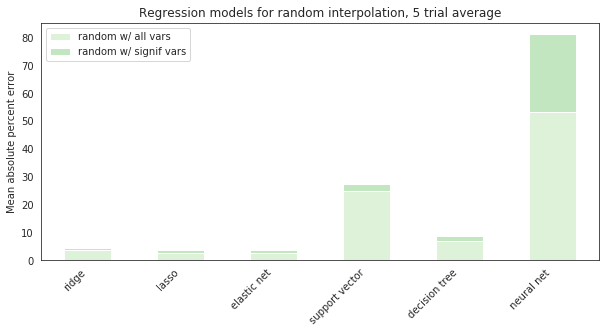

In [159]:
f, ax = plt.subplots(figsize=(10,5)) 
ranres.drop(columns=['ols linreg']).T.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=45,ha="right")
ax.set_ylabel("Mean absolute percent error")
ax.set_title("Regression models for random interpolation, 5 trial average")
plt.gcf().subplots_adjust(bottom=0.22)
f.savefig("figures/regression/regression_all_random.png",dpi=300)

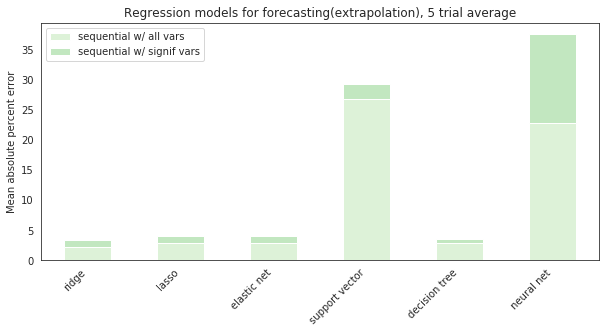

In [154]:
f, ax = plt.subplots(figsize=(10,5)) 
seqres.drop(columns=['ols linreg']).T.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=45,ha="right")
ax.set_ylabel("Mean absolute percent error")
ax.set_title("Regression models for forecasting(extrapolation), 5 trial average")
plt.gcf().subplots_adjust(bottom=0.22)
f.savefig("figures/withtol/regression_all_seq.png",dpi=300)

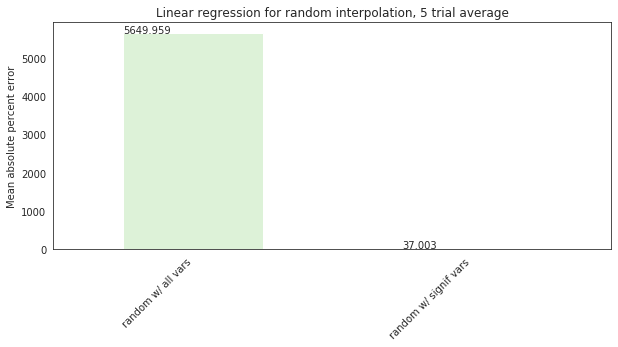

In [155]:
f, ax = plt.subplots(figsize=(10,5)) 
ranres['ols linreg'].plot(kind='bar', ax=ax)
plt.xticks(rotation=45,ha="right")
ax.set_ylabel("Mean absolute percent error")
ax.set_title("Linear regression for random interpolation, 5 trial average")
plt.gcf().subplots_adjust(bottom=0.25)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x(), p.get_height()*1.001))
f.savefig("figures/regression/olsLinRegRan.png",dpi=300)

In [157]:
f, ax = plt.subplots(figsize=(10,5)) 
seqres['ols linreg'].plot(kind='bar', ax=ax)
plt.xticks(rotation=45,ha="right")
ax.set_ylabel("Mean absolute percent error")
ax.set_title("Linear regression for forecasting(extrapolation), 5 trial average")
plt.gcf().subplots_adjust(bottom=0.3)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x(), p.get_height()*1.001))
f.savefig("figures/regression/olsLinRegSeq.png",dpi=300)